In this notebook we are writing an electrostatic PIC code. The standard references on PIC are Birdsall & Langdon and Hockney & Eastwood

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import os

In [33]:
#Graph Parameters
plt.rcParams['figure.figsize'] = 12,8
plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 18,
                     'legend.fontsize': 18})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2.5

In [17]:
#initialize nparts particles
def init_particles(nparts, L, vth_e):
    rng = np.random.default_rng(12345)
    xp = L*rng.random(nparts) #particle positions are uniformly distibuted in [0, L]
    #xp = np.random.uniform(low = L/4, high = 3*L/8, size = nparts//2)
    #xp = np.append(xp, np.random.uniform(low = L - L/4, high = L - 3*L/8, size = nparts//2) )
    #vp = np.random.normal(loc=0, scale=vth_e, size=nparts) #particle velocities have a normal distribution
    vp = rng.normal(loc=3*vth_e, scale=vth_e, size=nparts//2)
    vp = np.append(vp, rng.normal(loc=-3*vth_e, scale=vth_e, size=nparts - nparts//2))
    return xp, vp

Interpolation

NGP: $W(x) = 1$ for $|x|<dx/2$; = 0.5 for $x = dx/2$; = 0 otherwise

CIC: $W(x) = 1 - |x|/dx$ for $|x|<dx$; = 0 otherwise

In [18]:
#given particle position, return its contribution to number density
def Wt_fn(xi, rp, dx, interpolation = 'NGP'):
    if (interpolation == 'NGP'):
        return Wt_NGP(xi, rp, dx)
    elif (interpolation == 'CIC'):
        return Wt_CIC(xi, rp, dx)
    else:
        print ("Illegal option for Wt_fn")
        return
    
#NGP weight function; Following convention in Eq. (2-28) of Hockney & Eastwood
def Wt_NGP(xi, rp, dx): #xi: grid location; rp: particle location; dx: grid spacing
    if (abs(xi-rp) < 0.5*dx):
        return 1
    elif (abs(xi-rp) == 0.5*dx):
        return 0.5
    else:
        return 0

#CIC weight function
def Wt_CIC(xi, rp, dx): #xj: grid location; ri: particle location; dx: grid spacing
    if (abs(xi-rp) < dx):
        return (dx - abs(xi-rp))/dx
    else:
        return 0

In [19]:
#find the cell coordinates between which the particle lies; uses bisection
def left_right(xpp, x): #given particle coordinate and grid, find the left & right grids
    dx = x[1] - x[0]
    imin = int(xpp//dx)
    imax = imin + 1
    '''
    #no need for bisection for uniform grid!
    imax = np.size(x)-1
    imin = 0
    while (imax > imin+1):
        imid = (imin+imax)//2
        if (xpp < x[imid]):
            imax = imid
        if (xpp > x[imid]):
            imin = imid
    '''
    return imin, imax

$E = -\frac{d\phi}{dx}$ 

In [20]:
#calculate Electric field on the grid
def Efield_calc(phi, dx):
    
    nc = np.size(phi)
    E = 0.0*phi
    E[0] = -0.5*(phi[1]-phi[nc-2])/dx
    for i in range(1,nc-1):
        E[i] = -0.5*(phi[i+1]-phi[i-1])/dx
        
    E[nc-1] = -0.5*(phi[1]-phi[nc-2])/dx

    return E

In [21]:
#calculate electron density on grid, given the electron positions
def elec_dens(xp, x, interpolation = 'NGP'): 
    L = x[-1]-x[0]
    xp = xp%L
    dx = x[1] - x[0]
    nc = np.size(x)
    ne_dens = np.zeros(nc)
    for xpp in xp: 
        imin, imax = left_right(xpp, x) #find the cell coordinates between which the particle lies
        ne_dens[imin] += Wt_fn(x[imin], xpp, dx, interpolation)
        ne_dens[imax] += Wt_fn(x[imax], xpp, dx, interpolation)
        
    ne_dens[0] += ne_dens[nc-1] #apply periodic BCs on electron number density
    ne_dens[nc-1] = ne_dens[0]
    
    ne_dens /= dx
        
    return ne_dens

In [22]:
def dump_fields(nfile, x, rho, phi, E, time, out_dir):
    np.savetxt(out_dir+'fields_'+str(nfile)+'.dat', np.c_[x, rho, phi, E], header = 'x, rho, phi, E at time = '+str(time))

def dump_particles(nfile, xp, vp, time, out_dir):
    np.savetxt(out_dir+'particles_'+str(nfile)+'.dat', np.c_[xp, vp], header = 'xp, vp at time = '+str(time))

electrostatic Poisson equation: $\frac{d^2 \phi}{dx^2} = -4 \pi \rho$

below we are solving: $\frac{d^2 \phi}{dx^2} = RHS$

In [23]:
def potl_calc(rhs, dx, poisson_method='MAT'):
    if (poisson_method == 'MAT'):
        return potl_calc_mat(rhs, dx)
    elif (poisson_method == 'FFT'):
        return potl_calc_fft(rhs, dx)
    else:
        print("Illegal option for Poisson solver")
        return

def potl_calc_mat(rhs, dx):
#following is from Hockney & Eastwood; pg. 37 
    nc = np.size(rhs)
    phi = 0.0*rhs #phi assumed to be zero at end-points
    
    for i in range(1,nc):
        phi[1] += i*rhs[i]
        
    phi[1] /= (nc-1)
    phi[2] = rhs[1] + 2*phi[1]
    
    for i in range(3, nc):
        phi[i] = rhs[i-1] + 2*phi[i-1] - phi[i-2]
        
    phi *= dx*dx

    return phi

#solving Poisson eq in Fourier space
def potl_calc_fft(rhs, dx):
    nc = np.size(rhs)
    L = (nc-1)*dx #periodic box size
    rhs_k = np.fft.rfft(rhs[:-1])
            
    k = 2.*np.pi*np.arange((nc-1)//2+1)/L #wavenumber; using reality of rho
    phi_k = -rhs_k/(k*k + (2*np.pi/L)*(2*np.pi/L)*1e-30) #avoid 0/0 form
    phi_k[0] = 0.0 #k=0 mode has zero amplitude since mean density is zero; set to zero by hand
        
    phi = np.fft.irfft(phi_k, nc-1) #like rhs, phi in x- space should be real
        
    phi -= phi[0] #make phi at boundaries zero, this freedom is available even with periodic BCs since Poisson eq is second order
    
    phi = np.append(phi, phi[0]) #imposing periodic BCs at outer boundary
     
    return phi

In [24]:
#starting of the main program
#using CGS units; physical parameters and constants
e = 5.e-10 #charge of an electron
me = 9.1e-27 #mass of an electron
kB = 1.4e-14 #Boltzmann constant

#numerical parameters
#charge to mass ratio of superparticles = that of an electron
Ns = 1.e5 #number of electrons in a super-particle
ppc = 20 #particles per cell
nc = 1000 #number of cells 
nparts = nc*ppc #total number of particles
LbyLD = 100 #box-length in terms of Debye length

#physical parameters
Te = 1.e6 #electron temperature
vth_e = np.sqrt(kB*Te/(Ns*me)) #isothermal speed of electrons

#box-size & Debye length, number density, plasma frequency
L = vth_e*vth_e*LbyLD*LbyLD*me/(4*np.pi*Ns*e*e*nparts) #box-size
#print(L)
lam_D = L/LbyLD #Debye length 
n0 = nparts/L #number density of particles
wp = np.sqrt(4.*np.pi*n0*Ns*e*e/me) #plasma frequency

x = np.linspace(0,L,nc+1) #grid cell edges x[0] is same as x[nc] under periodic BCs; fields are located at cell edges
dx = x[1]-x[0] #uniform grid spacing

In [83]:
#time parameters
dt = 0.1/wp
tend = 25*2*np.pi/wp #run for few plasma periods
time = 0
n_dump = 60
n_hist = 100
#dt_dump, dt_hist = tend/20, tend/100 #time difference between dumps of fields & particles and history files
#t_dump, t_hist = 0, 0
#dump, hist = True, True #want outputs at t=0
#nfile_dump = 0

In [84]:
interpolation = 'CIC' #interpolation method for charge & acceleration
poisson_method = 'FFT' #method to solve Poisson equation

#initialization
xp, vp = init_particles(nparts, L, vth_e) #initialize particles at same time

In [85]:
def get_acc_p(xp, dx, x, Ns, e, me, interpolation, poisson_method):
    #L = x[-1]-x[0]
    #xp = xp%L #place the particles within the box
    ne_dens = elec_dens(xp, x, interpolation) #calculate electron density over the grid from electron locations
    #edge electron densities are same and should not be counted twice in averaging
    ni_dens = np.mean(ne_dens[:-1]) #ion density = average electron density (constant in time)
    rho = Ns*e*(ni_dens - ne_dens) #charge density on the grid, with neutralizing ion background
    phi = potl_calc(-4*np.pi*rho, dx, poisson_method) #calculate potential, given the charge density
    E = Efield_calc(phi, dx) #calculate E, given the potential
    acc = -e*E/me #acceleration over the grid
    
    #now calculate acceleration at the particle location
    nparts = np.size(xp)
    acc_loc = np.zeros(nparts)

    for p in range(nparts):
        imin, imax = left_right(xp[p], x) #find the cell coordinates between which the particle lies
        acc_loc[p] = acc[imin]*Wt_fn(x[imin], xp[p], dx, interpolation) + acc[imax]*Wt_fn(x[imax], xp[p], dx, interpolation) #calculate acceleration at the location of particles
    return acc_loc

def fun_pp(t, y, dx, x, Ns, e, me, interpolation, poisson_method): #RHS of particle evolution equation
    nparts = np.size(y)//2
    rhs_pp = np.zeros(2*nparts) 
    rhs_pp[:nparts] = y[nparts:] #dx_p/dt = v_p
    L = x[-1]-x[0]
    y[:nparts] = y[:nparts]%L
    rhs_pp[nparts:] = get_acc_p(y[:nparts], dx, x, Ns, e, me, interpolation, poisson_method) #get a_p at particle location; dv_p/dt = a_p
    return rhs_pp

In [86]:
#now evolve equations in time
t_eval = np.linspace(0,tend,max(n_dump, n_hist)+1)
sol = solve_ivp(fun_pp, [0,tend], np.append(xp, vp), t_eval = np.linspace(0,tend,max(n_dump, n_hist)+1), args = (dx, x, Ns, e, me, interpolation, poisson_method), method = 'RK45')

In [29]:
sol.y[:nparts,:] = sol.y[:nparts,:]%L #bring particles back in domain if they have moved out in the last update

In [87]:
#create directory to dump data
out_dir = os.getcwd()+'/RK/'
if (os.path.exists(out_dir) == False):
    os.mkdir(out_dir)
    
#output diagnostics
time_hist, KE_hist, PE_hist, totE_hist = [], [], [], [] #initialize list of quantities to be dumped in history dump
t_dump, t_hist = 0, 0
dt_dump, dt_hist = (t_eval[-1]-t_eval[0])/n_dump, (t_eval[-1]-t_eval[0])/n_hist
nfile_dump = 0
for i in range(np.size(t_eval)):
    if (t_dump <= t_eval[i] or t_eval[i] == tend):
        #get rho, phi, E from xp, vp
        ne_dens = elec_dens(sol.y[:nparts,i], x, interpolation) #calculate electron density over the grid from electron locations
        #edge electron densities are same and should not be counted twice in averaging
        ni_dens = np.mean(ne_dens[:-1]) #ion density = average electron density (constant in time)
        rho = Ns*e*(ni_dens - ne_dens) #charge density on the grid, with neutralizing ion background
        phi = potl_calc(-4*np.pi*rho, dx, poisson_method) #calculate potential, given the charge density
        E = Efield_calc(phi, dx) #calculate E, given the potential
        dump_fields(nfile_dump, x, rho, phi, E, t_eval[i], out_dir)
        dump_particles(nfile_dump, sol.y[:nparts,i], sol.y[nparts:,i], t_eval[i], out_dir)
        nfile_dump += 1
        t_dump += dt_dump
    if (t_hist <= t_eval[i] or t_eval[i] == tend):
        time_hist.append(t_eval[i])
        kin_energy = 0.5*Ns*me*np.sum(sol.y[nparts:,i]*sol.y[nparts:,i])
        KE_hist.append(kin_energy)
        #get rho, phi, E from xp, vp
        ne_dens = elec_dens(sol.y[:nparts,i], x, interpolation) #calculate electron density over the grid from electron locations
        #edge electron densities are same and should not be counted twice in averaging
        ni_dens = np.mean(ne_dens[:-1]) #ion density = average electron density (constant in time)
        rho = Ns*e*(ni_dens - ne_dens) #charge density on the grid, with neutralizing ion background
        phi = potl_calc(-4*np.pi*rho, dx, poisson_method) #calculate potential, given the charge density
        pot_energy = 0.5*dx*np.sum(rho*phi) #0.5 in PE necessary since this is self-consistent field
        PE_hist.append(pot_energy)
        totE_hist.append(kin_energy+pot_energy)
        t_hist += dt_hist

np.savetxt(out_dir+'hist.dat', np.c_[time_hist, KE_hist, PE_hist, totE_hist], header = 'time, KE, PE, total energy')

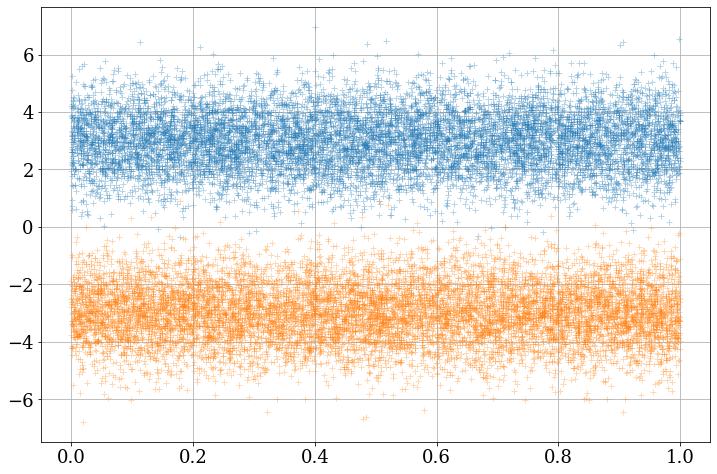

In [88]:
#plot phase-space plots
D = np.loadtxt(out_dir+'particles_0.dat')
plt.plot(D[:10000,0]/L,D[:10000,1]/vth_e,'+', alpha=0.3, label='t=0')
plt.plot(D[10000:,0]/L,D[10000:,1]/vth_e,'+', alpha=0.3, label='t=0')
plt.grid()

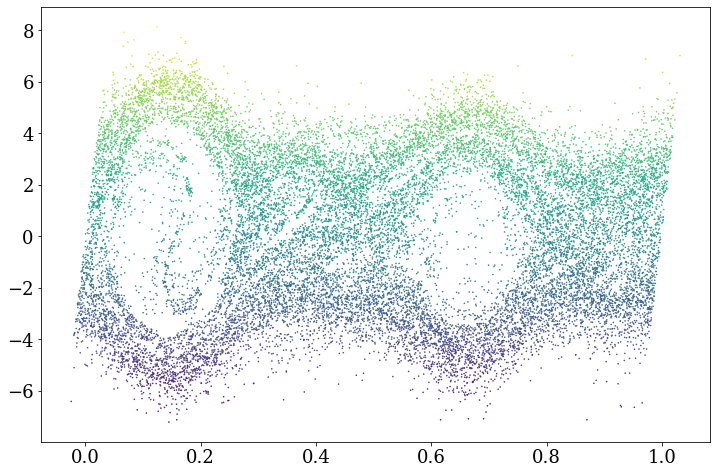

In [89]:

# D = np.loadtxt(out_dir+'particles_1.dat')
# plt.plot(D[:,0]/L,D[:,1]/vth_e,'^')

# D = np.loadtxt(out_dir+'particles_2.dat')
# plt.plot(D[:,0]/L,D[:,1]/vth_e,'^')


D = np.loadtxt(out_dir+'particles_20.dat')
plt.scatter(D[:,0]/L,D[:,1]/vth_e, c=(D[:,1]/vth_e), s=0.3, cmap='viridis', label='t=20')

# plt.legend()
# plt.grid()

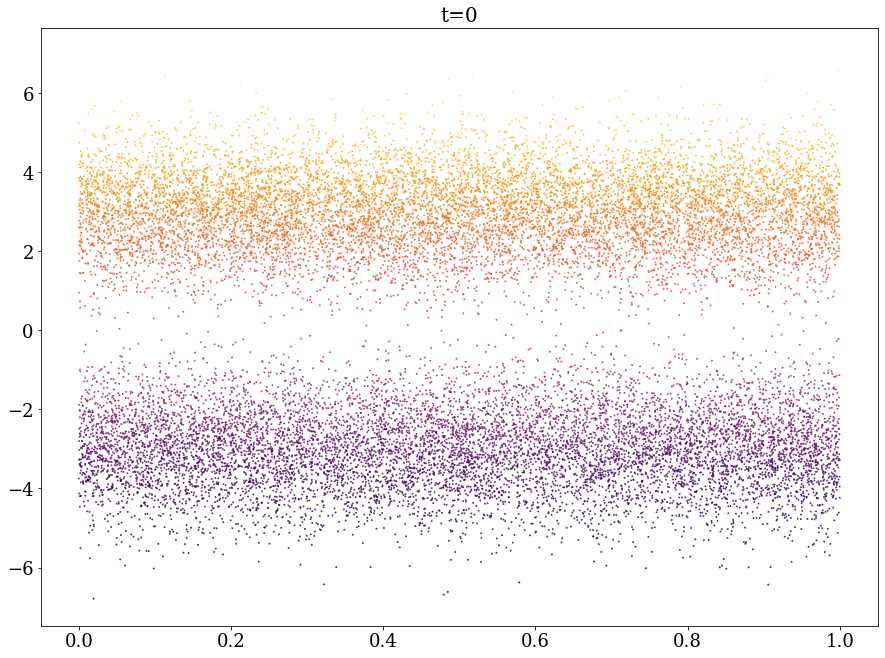

In [92]:
# making an animation from the data
import matplotlib.animation as animation

# init the figure
fig, ax = plt.subplots(figsize=(15,11))

def update(i):
    
    ax.clear()
    
    D = np.loadtxt(out_dir+'particles_%s.dat'%i)
    
    ax.scatter(D[:,0]/L,D[:,1]/vth_e, c=(D[:,1]/vth_e), cmap='inferno', s=1, alpha=0.7, label='t=%s'%i)
    plt.title('t=%s'%i)
    
plt.grid()
ani = animation.FuncAnimation(fig, update, frames=range(n_dump), interval=250)
ani.save('scatter.gif', writer='pillow')


In [ ]:

# init the figure
fig, ax = plt.subplots(figsize=(15,11))

def update(i):
    
    ax.clear()
    
    D = np.loadtxt(out_dir+'particles_%s.dat'%i)
    
    ax.scatter(D[:,0]/L,D[:,1]/vth_e, c=(D[:,1]/vth_e), cmap='inferno', s=1, alpha=0.7, label='t=%s'%i)
    plt.title('t=%s'%i)
    
plt.grid()
ani = animation.FuncAnimation(fig, update, frames=range(n_dump), interval=250)
ani.save('scatter.gif', writer='pillow')


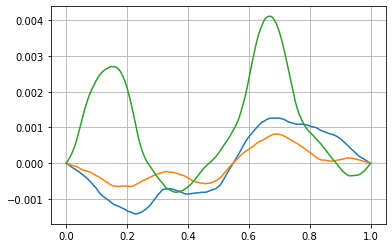

In [ ]:
#field profiles
D = np.loadtxt(out_dir+'fields_0.dat')
plt.plot(D[:,0]/L,D[:,2],'-')

D = np.loadtxt(out_dir+'fields_1.dat')
plt.plot(D[:,0]/L,D[:,2],'-')

D = np.loadtxt(out_dir+'fields_10.dat')
plt.plot(D[:,0]/L,D[:,2],'-')
plt.grid()

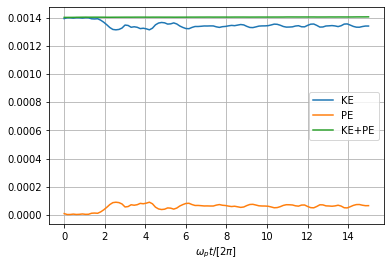

In [ ]:
#energy diagnostics
D = np.loadtxt(out_dir+'hist.dat')
tplot = D[:,0]*wp/(2*np.pi)
plt.plot(tplot, D[:,1], label = 'KE')
plt.plot(tplot, D[:,2], label = 'PE')
plt.plot(tplot, D[:,3], label = 'KE+PE')
plt.xlabel(r'$\omega_p t/[2\pi]$')
plt.legend()
plt.grid()
#plt.xlim([0.5,10])

In [ ]:
#basic checks, periodicity, etc.
print(nc)
print(phi[0], phi[nc])
print(rho[0], rho[nc])
print(E[0], E[nc])

1000
0.0 0.0
0.12783348870538758 0.12783348870538758
-0.0866425407773579 -0.0866425407773579
